In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
from scipy.stats import false_discovery_control
%load_ext rpy2.ipython
import pandas as pd

Now, lets look at if pupil size is responding to how much bigger losses are than equivalent gains

In [2]:
behavior = load_behavioral_data(min_RT = 0.2)
behavior = pd.read_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/behavioral_data_SVs.csv")
behavior = behavior[["sub", "trial", "RT", "delta_SV", "condition", "accept", "subj_value_norm"]]
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]

In [3]:
# data["loss_gain"] = np.log(data["loss"] / data["gain"])

In [4]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(broom.mixed)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



First, we examine if there are differences in the interaction between stimuli and pupil size. 

In [6]:
%%R -o results
# loop through timebins
results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ subj_value_norm*condition + RT*condition + delta_SV*condition + (1| sub) + (-1 + RT|sub) + (-1 + subj_value_norm|sub) + (-1 + delta_SV | sub), data=data[data$timebin == tb, ])
    # Gather results
    model_result <- tidy(model, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    model_result$timebin <- tb
    # Append results
    results <- rbind(results, model_result)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00409391 (tol = 0.002, component 1)
2: Model failed to converge with 1 negative eigenvalue: -3.6e+02 
3: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00231435 (tol = 0.002, component 1)
4: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$

In [25]:
%%R -o results
# loop through timebins
results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ poly(loss_gain, 2)*condition + RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain|sub), data=data[data$timebin == tb, ])
    # Gather results
    model_result <- tidy(model, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    model_result$timebin <- tb
    # Append results
    results <- rbind(results, model_result)
}

boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00658915 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00568536 (tol = 0.002, component 1)


In [7]:
results["p.value"] = false_discovery_control(results["p.value"], method = "by")
results = results.rename(columns={"p.value": "p_value"})

In [8]:
# From this, all I want to look is at the pvalues that are significant
results = results.query("p_value < 0.05 & term.str.contains('conditionequalRange')")

In [9]:
results

,effect,term,estimate,std.error,statistic,df,p_value,conf.low,conf.high,timebin
86,fixed,subj_value_norm:conditionequalRange,0.280455,0.075722,3.703730,50.565525,0.016179,0.128405,0.432506,1.290323
94,fixed,subj_value_norm:conditionequalRange,0.337659,0.079895,4.226286,50.698621,0.003645,0.177240,0.498078,1.419355
102,fixed,subj_value_norm:conditionequalRange,0.389241,0.084728,4.594001,50.734931,0.001313,0.219121,0.559362,1.548387
110,fixed,subj_value_norm:conditionequalRange,0.425697,0.089037,4.781114,50.584226,0.000807,0.246912,0.604483,1.677419
118,fixed,subj_value_norm:conditionequalRange,0.445064,0.095088,4.680564,50.877254,0.001056,0.254156,0.635972,1.806452
126,fixed,subj_value_norm:conditionequalRange,0.470332,0.104313,4.508855,51.558792,0.001648,0.260970,0.679694,1.935484
134,fixed,subj_value_norm:conditionequalRange,0.495754,0.110426,4.489474,52.043687,0.001689,0.274173,0.717335,2.064516
142,fixed,subj_value_norm:conditionequalRange,0.504596,0.110159,4.580631,51.984263,0.001313,0.283545,0.725647,2.193548
150,fixed,subj_value_norm:conditionequalRange,0.486010,0.109014,4.458245,51.557168,0.001851,0.267213,0.704807,2.322581
158,fixed,subj_value_norm:conditionequalRange,0.465118,0.108895,4.271269,51.363168,0.003296,0.246541,0.683695,2.451613


In [26]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ delta_SV + subj_value_norm + RT + (1| sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ delta_SV + subj_value_norm + RT + (1| sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb

    # Add convergence and singular fit info
    resultsIndifference$converged <- summary(modelIndifference)$optinfo$conv$converged
    resultsRange$converged <- summary(modelRange)$optinfo$conv$converged
    resultsIndifference$singular <- isSingular(modelIndifference, tol = 1e-4)
    resultsRange$singular <- isSingular(modelRange, tol = 1e-4)
    
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

In [32]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ poly(loss_gain, 2) + RT + blink + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ poly(loss_gain, 2) + blink + RT + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00686687 (tol = 0.002, component 1)


In [27]:
results_individual["p.value"] = false_discovery_control(results_individual["p.value"], method = "by")
results_individual = results_individual.rename(columns={"p.value": "p_value"})

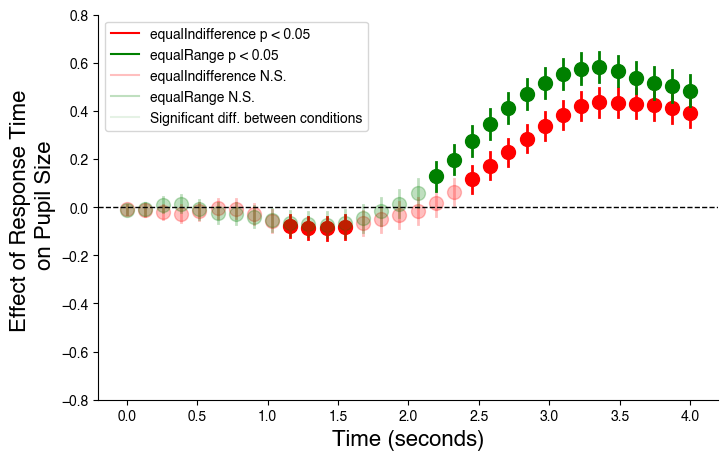

In [28]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'RT'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "green"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "green", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "green", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Response Time \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if linear_term.shape[0] > 0:
#     ax.axvspan(min(linear_term), max(linear_term), color="green", alpha=0.1)
ax.set_ylim(-0.8, 0.8)
plt.show()

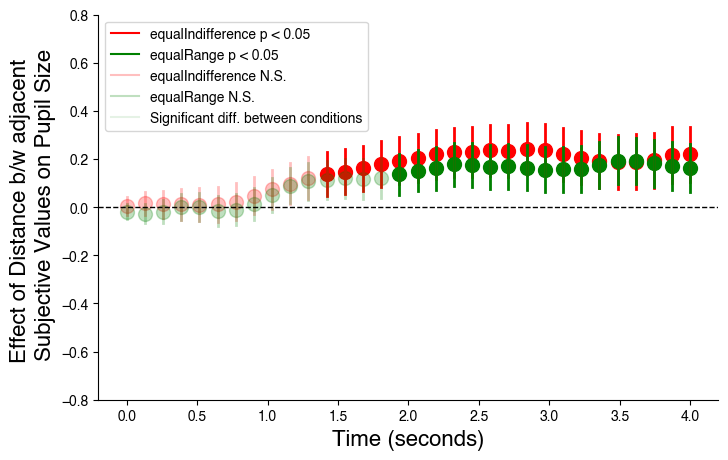

In [29]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'delta_SV'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "green"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "green", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "green", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Distance b/w adjacent \n Subjective Values on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
ax.set_ylim(-0.8, 0.8)
plt.show()

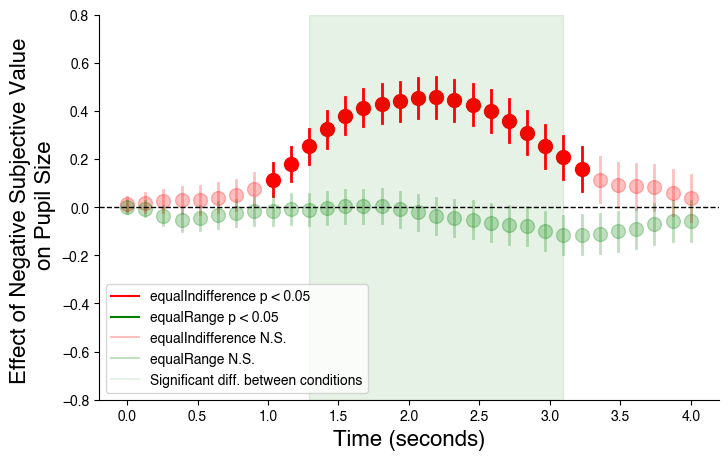

In [30]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'subj_value_norm'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "green"
    ax.plot([row["timebin"], row["timebin"]], [-row["conf.low"], -row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], -row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "green", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "green", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Negative Subjective Value \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
ax.axvspan(1.290323, 3.096774, color="green", alpha=0.1)
ax.set_ylim(-0.8, 0.8)
plt.show()

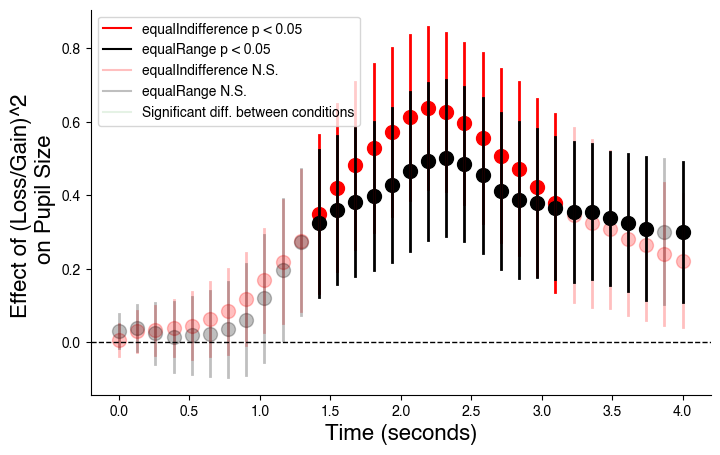

In [23]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'sq_break'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of (Loss/Gain)^2 \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
# ax.set_ylim(-7, 17)
plt.show()